In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
# os.environ['CUDA_LAUNCH_BLOCKING'] = "0"

In [2]:
!nvidia-smi

Wed Mar 13 12:36:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           Off | 00000000:89:00.0 Off |                    0 |
| N/A   28C    P0              55W / 300W |      0MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import zipfile
import shutil
import time
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from tqdm import tqdm_gui
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import RandomVerticalFlip

%matplotlib inline

In [4]:
device = torch.device("cuda")

In [5]:
directory = 'simpsons_dataset/'
classes = os.listdir(directory)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  #преобразует пиксели из диапазона [0,1] в диапазон [-1,1]
])

data_dir = 'simpsons_dataset/'

dataset = ImageFolder(root=data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print("Классы:", dataset.classes)

print(len(dataset.classes))

Классы: ['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']
42


In [6]:
directory = 'kaggle_simpson_testset/kaggle_simpson_testset/'

test_classes = []
test_images = []

def del_digit(img_name):
  for char in img_name:
    if char.isdigit():
      img_name = img_name.replace(char, '')

  clas = img_name[:-5]
  test_classes.append(dataset.class_to_idx[clas])

test_imgs = os.listdir(directory)
for img in test_imgs:
  image_path = directory + img
  image = Image.open(image_path)
  test_images.append(transform(image).unsqueeze(0))
  del_digit(img)

In [7]:
class My_CNN(nn.Module):
    def __init__(self, num_classes):
        super(My_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 16 * 16, 256)
        #self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        #self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 16 * 16)
        #x = x.view(-1, 64 * 32 * 32)
        x = self.relu(self.fc1(x))
        #x = self.dropout(x)
        x = self.fc2(x)
        return x
        


In [8]:
batch_size = 1024
learning_rate = 0.001
num_epochs = 15

train_losses, val_losses = [], []
train_accuracy, val_accuracy = [], []

model = My_CNN(num_classes = 42).cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

def learning():
  for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
      images, labels = images.cuda(), labels.cuda()
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

    end_time = time.time()
    epoch_time = end_time - start_time

    train_loss = running_loss/len(train_dataloader)
    train_losses.append(loss)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {loss}, time = {epoch_time}")

    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_dataloader)
    val_losses.append(val_loss)
    val_accuracy = correct / total
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

In [9]:
learning()

Epoch 1/15
Train Loss: 2.880011558532715, time = 48.74940729141235
Validation Loss: 2.767892932891846, Validation Accuracy: 0.23572963935992358
Epoch 2/15
Train Loss: 2.3956925868988037, time = 46.91324853897095
Validation Loss: 2.2413769245147703, Validation Accuracy: 0.37735849056603776
Epoch 3/15
Train Loss: 1.870298981666565, time = 46.42083787918091
Validation Loss: 1.9127568006515503, Validation Accuracy: 0.49008836876044903
Epoch 4/15
Train Loss: 1.7934669256210327, time = 45.922199964523315
Validation Loss: 1.6954957485198974, Validation Accuracy: 0.5364222593742537
Epoch 5/15
Train Loss: 1.6477813720703125, time = 45.98270535469055
Validation Loss: 1.5222333908081054, Validation Accuracy: 0.579651301647958
Epoch 6/15
Train Loss: 1.5136529207229614, time = 45.838539123535156
Validation Loss: 1.438590693473816, Validation Accuracy: 0.5975638882254598
Epoch 7/15
Train Loss: 1.3269990682601929, time = 45.850271224975586
Validation Loss: 1.3221035242080688, Validation Accuracy: 0.6

In [20]:
path_to_weights = 'weights/weigths_15ep_512n_128x128+dropout.pth'
torch.save(model.state_dict(), path_to_weights)

In [21]:
model = My_CNN(num_classes = 42).cuda()
model.load_state_dict(torch.load(path_to_weights, map_location=torch.device('cuda')))

<All keys matched successfully>

In [22]:
model.eval()

true = 0
total = len(test_images)

for image, label in zip(test_images, test_classes):
    outputs = model(image.cuda())
    if torch.argmax(outputs) == label:
      true += 1

test_accuracy = true/total

print(test_accuracy)

0.8888888888888888


In [13]:
def predict_model(image):
    image = Image.open(image)
    
    plt.imshow(image.resize((128,128)))
    plt.show()
    
    input_image = transform(image).unsqueeze(0)
    
    with torch.no_grad():
        model.eval()
        output = model(input_image.cuda())
        output = np.argmax(output.detach().cpu().numpy())
        print(dataset.classes[output])


In [23]:
train_losses = [tensor.detach().cpu().numpy() for tensor in train_losses]

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

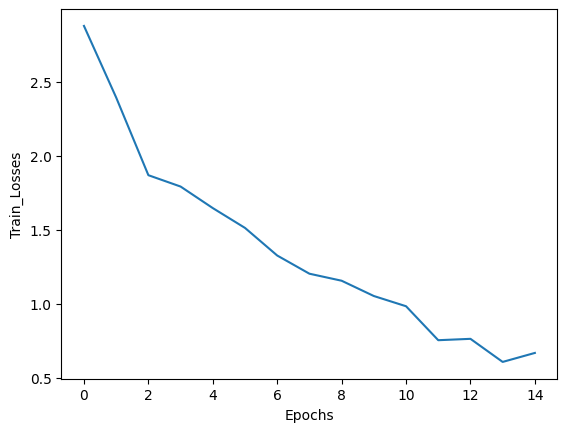

In [24]:
path_to_train_graphic = 'graphics/train_losses/train_losses_50e_512n_128x128+dropout.png'

epochs = [epoch for epoch in range(num_epochs)]
plt.plot(epochs, train_losses)
plt.xlabel('Epochs')
plt.ylabel('Train_Losses')
plt.savefig(path_to_train_graphic)
plt.show()

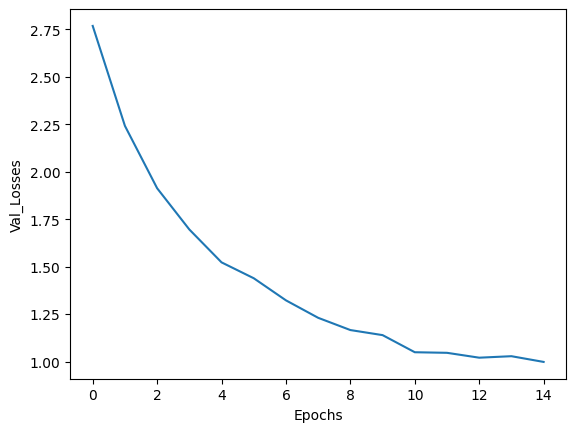

In [25]:
path_to_val_graphic = 'graphics/val_losses/val_losses_50e_512n_128x128+dropout.png'

plt.plot(epochs, val_losses)
plt.xlabel('Epochs')
plt.ylabel('Val_Losses')
plt.savefig(path_to_val_graphic)
plt.show()

In [26]:
!pwd

/home/i.zolotykh/Artificial-intelligence/jupiter_notebook/simpsons
